# Simpson

## Importar

In [1]:
# %load basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Diplomado/data/Mod_III/'
os.listdir(liga)

['pokemon (1).csv',
 'pokemon_cluster.csv',
 'simpsons_characters.csv',
 'ratings.csv',
 'datapackage.json',
 'pokemon_cluster',
 'tags.csv',
 'simpsons_episodes.csv',
 'simpsons_locations.csv',
 'digits_train_sample.csv',
 'movies.csv',
 'simpsons_script_lines.csv',
 'simpson_limpio.csv',
 'fake_news.csv']

In [2]:
[x for x in os.listdir(liga) if x.startswith('simp')]

['simpsons_characters.csv',
 'simpsons_episodes.csv',
 'simpsons_locations.csv',
 'simpsons_script_lines.csv',
 'simpson_limpio.csv']

In [3]:
df = pd.read_csv(liga + 'simpsons_script_lines.csv')
df.dropna(inplace = True)
print(df.shape)
df.sample(4)

/home/ef/Desktop/diplomadus/diplomadus/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(131708, 13)


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
17358,27020,91,221,Marge Simpson: What happened here?,1035000,True,1.00,5.00,Marge Simpson,Simpson Home,What happened here?,what happened here,3
4701,14255,47,249,Marge Simpson: (TURNING) Homer ?! (DISAPPOINTE...,1012000,True,1.00,389.00,Marge Simpson,Bouvier House,Homer ?!,homer,1
102520,112602,395,87,"Troll Moe: What? No, my character's supposed t...",391000,True,4926.00,3260.00,Troll Moe,EARTHLAND REALMS,"What? No, my character's supposed to look like...",what no my characters supposed to look like me...,17
111361,121531,429,118,"Prof. Hobbes: Ah, track three, ""Researching Th...",598000,True,5303.00,3522.00,Prof. Hobbes,HOBBES HOUSE,"Ah, track three, ""Researching The Brief.""",ah track three researching the brief,6


## Funciones

In [4]:
'''
#Activar si es la primera vez que se ocupan stopwords o Lemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
'''
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def clean_text(text,language = 'english',
               add_stopwords = [], 
               pattern ='[^a-zA-Z]'):
    cleaned_text = unicodedata.normalize('NFD', str(text)).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, ' ', 
                          cleaned_text.decode('utf-8'), 
                          flags = re.UNICODE)
    cleaned_text = ' '.join([lem.lemmatize(word) for word in 
                             cleaned_text.lower().split() if word not in 
                             stopwords.words(language) + add_stopwords])
    return cleaned_text

In [5]:
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(text):
    sid = SentimentIntensityAnalyzer()
    try:
        list(map(sid.polarity_scores,sent_tokenize(text)))[0]
    except:
        sentences = sent_tokenize('a')
    else:
        sentences = sent_tokenize(text)
    res = map(sid.polarity_scores, sentences)
    return list(res)[0]

In [6]:
from PIL import Image
from wordcloud import WordCloud

def get_wordcloud(text, image_dir, image_name, n_title = 20,repeat = False):
    #Sub-función para desplegar la imagen
    def plot_data(data):
      plt.imshow(data, interpolation='nearest')
      plt.show()
        
    ##IMPORTAR    
    orig = Image.open(image_dir + image_name)
    plot_data(np.array(orig))
    
    #AJUSTAR
    img = Image.new('RGB', orig.size, (255,255,255))
    try:
        img.paste(orig,orig) #ajusta la parte transparente pa que no se interprete como negro
    except:
        mask = np.array(orig)
    else:
        img.paste(orig,orig)
        mask = np.array(img) #convierte la imagen a datos (# de color)
    wordcloud = WordCloud(mask = mask, #lienzo para las palabras
                          #dirección de fuente (tipo de letra)
                          font_path = '/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf',
                          color_func = lambda *args, **kwargs: 'white', #letras blancas
                          include_numbers = True,
                          prefer_horizontal = 0.83, #porcentaje de palabras horizontales
                          background_color = 'black', 
                          max_words = 10000,
                          max_font_size = 73,
                          repeat = repeat) #se repiten las palabras?
    wordcloud.generate(text+(' '+image_name[:-4].replace('_','-')+' ')*n_title
                      ).to_file(image_dir +f'WP_{image_name[:-4]}.png') #guarda como png
    wordcloud = Image.open(image_dir +f'WP_{image_name[:-4]}.png').convert('RGBA')
    datas = wordcloud.getdata() #para obtener nuevamente la info en datos (RGBA contempla transparencia en el último elem)
    wordcloud.putdata([(255,255,255,0) if x[0]==x[1]==x[2]!=255 else x for x in datas]) #si el color no es blanco (letras) vuelve transparente al pixelo
    wordcloud.paste(orig, box = (0,0), mask = wordcloud) #se sobrepone contra la orignal
    wordcloud.save(image_dir +f'WP_{image_name[:-4]}.png') #guarda la nueva imagen como png
    display(wordcloud)

## EDA

In [7]:
import concurrent.futures

texto = 'normalized_text'
with concurrent.futures.ProcessPoolExecutor() as executor:
    limpio = list(executor.map(clean_text, df[texto]))

df[f'{texto}_limpio'] = list(map(lambda x:str(x),limpio))
df[f'{texto}_long'] = df[texto].str.len()
df[f'{texto}_n_words'] = df[texto].str.split().str.len()
df[f'{texto}_relevant'] = (df[f'{texto}_limpio'].str.len()+1) / (df[texto].str.len()+1)

df[[texto,f'{texto}_limpio',f'{texto}_long',
    f'{texto}_n_words',f'{texto}_relevant']].sample(7)

Process ForkProcess-4:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 97, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args,

KeyboardInterrupt: 

Process ForkProcess-2:
Process ForkProcess-3:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter

In [ ]:
import concurrent.futures

texto = 'normalized_text_limpio'
with concurrent.futures.ProcessPoolExecutor() as executor:
    sentim = pd.DataFrame(list(executor.map(sentiment,
                                            df[texto])))

df = df.iloc[:,:-4].reset_index(drop = True).join(sentim)
df.sample(4)

In [ ]:
df.to_csv(liga + 'simpson_limpio.csv', index = False)

## Wordcloud

In [ ]:
image_dir = '/home/ef/Desktop/diplomadus/diplomadus/_practicas/images/simpson/'
images = ['homer.jpg','marge.png','lisa.png','bart.png']
for image in images:
    texto = ' '.join(df[df['raw_character_text'] == f'{image[:-4].capitalize()} Simpson']['normalized_text_limpio'])
    get_wordcloud(texto,image_dir, image)

## TAD

In [84]:
df = pd.read_csv(liga + 'simpson_limpio.csv')

/home/ef/Desktop/diplomadus/diplomadus/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [85]:
num = [x for x in df.describe().columns]
cat = [x for x in df.columns if x not in num]

df = df[cat+num].copy()
df.sample()

,raw_text,speaking_line,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,normalized_text_limpio,id,episode_id,number,timestamp_in_ms,character_id,location_id,normalized_text_long,normalized_text_n_words,normalized_text_relevant,neg,neu,pos,compound
48175,Bart Simpson: (PUZZLED) You're not mad?,True,Bart Simpson,Springfield Elementary School,You're not mad?,youre not mad,3,youre mad,67187,235,133,573000,8.00,3.00,13,3,0.71,0.76,0.24,0.00,-0.49


In [86]:
ep = pd.read_csv(liga + 'simpsons_episodes.csv')
ep.sample()

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
82,222,http://static-media.fxx.com/img/FX_Networks_-_...,7.60,831.00,19,222,1999-04-11,1999,AABF15,10,Mom and Pop Art,8.50,http://www.simpsonsworld.com/video/310457411688,47851.00


In [87]:
df = df.merge(ep[['id','imdb_rating']], 
              left_on = 'episode_id', 
              right_on = 'id', 
              how = 'left')
df.columns

Index(['raw_text', 'speaking_line', 'raw_character_text', 'raw_location_text',
       'spoken_words', 'normalized_text', 'word_count',
       'normalized_text_limpio', 'id_x', 'episode_id', 'number',
       'timestamp_in_ms', 'character_id', 'location_id',
       'normalized_text_long', 'normalized_text_n_words',
       'normalized_text_relevant', 'neg', 'neu', 'pos', 'compound', 'id_y',
       'imdb_rating'],
      dtype='object')

In [88]:
df.sample()

,raw_text,speaking_line,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,normalized_text_limpio,id_x,episode_id,number,timestamp_in_ms,character_id,location_id,normalized_text_long,normalized_text_n_words,normalized_text_relevant,neg,neu,pos,compound,id_y,imdb_rating
91759,"Marge Simpson: (SING-SONG, ENTICING) They have...",True,Marge Simpson,Kozy Kabins,They have a pe-dal car.,they have a pe-dal car,5,pe dal car,120416,425,125,483000,1.00,3479.00,22,5,0.48,0.00,1.00,0.00,0.00,425,6.60


In [89]:
grupo = ['word_count', 'normalized_text_long','normalized_text_relevant', 
         'neg', 'neu','pos', 'compound', 'imdb_rating']

X = df.groupby('raw_character_text')[grupo].mean()

## Preprocesamiento

In [90]:
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler()

Xs = pd.DataFrame(mm_x.fit_transform(X),
                  index = X.index, 
                  columns = X.columns)

Xs.describe()

,normalized_text_long,normalized_text_relevant,neg,neu,pos,compound,imdb_rating
count,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00
mean,0.12,0.70,0.10,0.71,0.17,0.53,0.62
std,0.08,0.15,0.17,0.25,0.20,0.14,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.06,0.62,0.00,0.57,0.00,0.49,0.52
50%,0.10,0.69,0.00,0.72,0.14,0.50,0.60
75%,0.15,0.78,0.14,1.00,0.27,0.60,0.73
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Clúster

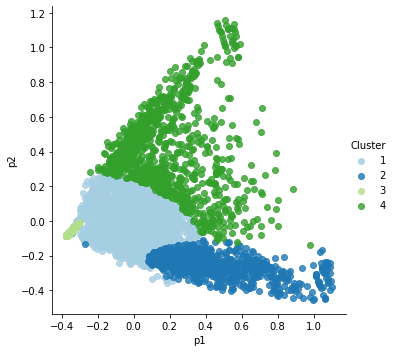

In [91]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

cluster = GaussianMixture(n_components = 4, random_state = 22)
pca = PCA(n_components = 2)
Xa = pd.DataFrame(pca.fit_transform(Xs),
                  index = Xs.index, 
                  columns=["p1", "p2"])

X['Cluster'] = Xa['Cluster'] = (cluster.fit_predict(Xa) + 1).astype(str)
sns.lmplot(data = Xa,
           x = 'p1',
           y = 'p2',
           fit_reg = False, 
           hue = 'Cluster', 
           palette = 'Paired')

In [92]:
df = df.set_index('raw_character_text').join(Xa['Cluster'])

In [93]:
df.groupby('Cluster').mean().transpose()

Cluster,1,2,3,4
speaking_line,True,True,True,True
id_x,78343.73,77317.52,81453.25,82016.82
episode_id,275.55,271.77,286.46,288.45
number,142.64,141.88,136.65,149.39
timestamp_in_ms,667155.66,653864.08,644425.24,694579.25
character_id,534.12,3218.03,3447.49,3323.52
location_id,814.51,1123.10,1148.00,1162.52
normalized_text_long,49.76,52.04,32.83,47.76
normalized_text_n_words,9.95,10.19,6.46,9.45
normalized_text_relevant,0.69,0.71,0.75,0.66


In [94]:
simp = [x for x in set(df.reset_index()['raw_character_text']) if x.endswith('Simpson')]

aux = df.reset_index()[['raw_character_text','Cluster']]

lista = []
for x,y in zip(aux['raw_character_text'],aux['Cluster']):
    if x in simp:
        lista.append(x + str(y))
        

set(lista)

{'Bart Simpson1',
 'Dr. Simpson1',
 'Grampa Simpson1',
 'Great Grampa Simpson3',
 'Homer Simpson1',
 'Lisa Simpson1',
 'Maggie Simpson1',
 'Marge Simpson1',
 'Mona Simpson1',
 'Virgil Simpson1'}

In [96]:
X['Cluster'].value_counts(1)

1   0.43
3   0.26
4   0.16
2   0.15
Name: Cluster, dtype: float64